In [153]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Differentialgleichungen

### Wasserbilanz

Wir berechnen zunächst das Beispiel der mittleren Wasserbilanz in Deutschland. Diese lösen wir analytisch und berechnen sie numerisch mit der Euler und RungeKutta Methode.

In [154]:
P = 2.173 # Mittlerer täglicher Niederschlag [mm/d]
ET = 1.377 # Mittlere täglichen Evapotranspiration [mm/d]
alpha = 1

vereinfachte Wasserbilanzgleichung:
$$\frac{dS}{dt} = P - ET - \alpha * S $$


In [155]:

def dSdt(S_temp, alpha = 1):
    return (P - ET - alpha*S_temp)

Analytische Lösung:

$$ S(t) = - \frac{(P - ET)}{\alpha} * exp(-\alpha *t) +\frac{(P - ET)}{\alpha}$$

In [156]:
def S_ana(t):
    St = -((P - ET)/alpha)*np.exp(-alpha*t)+ (P - ET)/alpha
    return St
S_ana(5)

0.790636594188728

Euler Methode zur numerischen Lösung:

In [157]:
def euler(startwert,f, h, x0,xn):
    S = startwert
    x = np.arange(x0,xn + h/2,h)
    N = len(x)
    S_res = [S]

    for i in x[:-1]:
        dS = P - ET - alpha * S
        # print(dS)
        # dS = dSdt(S)
        S = S + h *dS
        S_res.append(S)
    
    return S_res, x


Runge Kutta Methode Stufe 4:

In [158]:
def runge_kutta4(startwert,f, h, x0,xn):
    S = startwert
    x = np.arange(x0,xn + h/2,h)
    N = len(x)
    S_res = [S]
    for i in range(N-1):
        k1 = h * f(S)
        k2 = h* f(S + 0.5*k1)
        k3 = h* f(S + 0.5*k2)
        k4 = h* f(S + k3)
        # print(k1, k2 ,k3,k4)
        S = S + (1/6*k1 + 2/6 * k2 + 2/6* k3 + 1/6* k4)
        S_res.append(S)
    return S_res, x

Numerische Lösung der Wasserbilanzgleichung mit verschiedenen Schrittweiten:

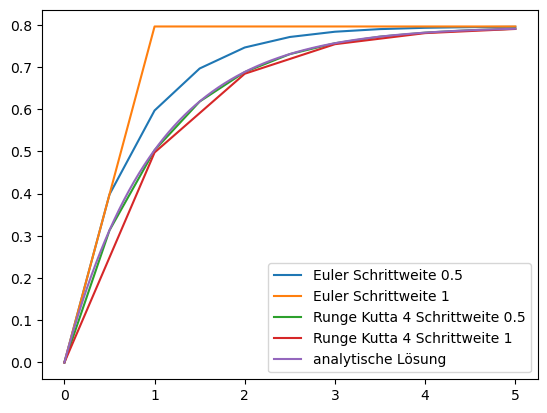

In [159]:

h = 0.5
y, x = euler(0,dSdt,h=h,x0=0,xn=5)
plt.plot(x,y,label=f"Euler Schrittweite {h}")
h = 1
y, x = euler(0,dSdt,h=h,x0=0,xn=5)
plt.plot(x,y,label=f"Euler Schrittweite {h}")
h = 0.5
y, x =runge_kutta4(0,dSdt,h=h,x0=0,xn=5)
plt.plot(x,y,label=f"Runge Kutta 4 Schrittweite {h}")
h = 1
y, x =runge_kutta4(0,dSdt,h=h,x0=0,xn=5)
plt.plot(x,y,label=f"Runge Kutta 4 Schrittweite {h}")

x = np.linspace(0,5,1000)
y_analytic = S_ana(x)
plt.plot(x,y_analytic,label="analytische Lösung")
plt.legend()
# plt.plot(runge_kutta4(0,dSdt,h=0.2,x0=0,xn=5))

Wir schauen uns nun den Fehler der numerischen Lösung der Euler und RungeKutta 4 Methode gegen die analytische Lösung an:

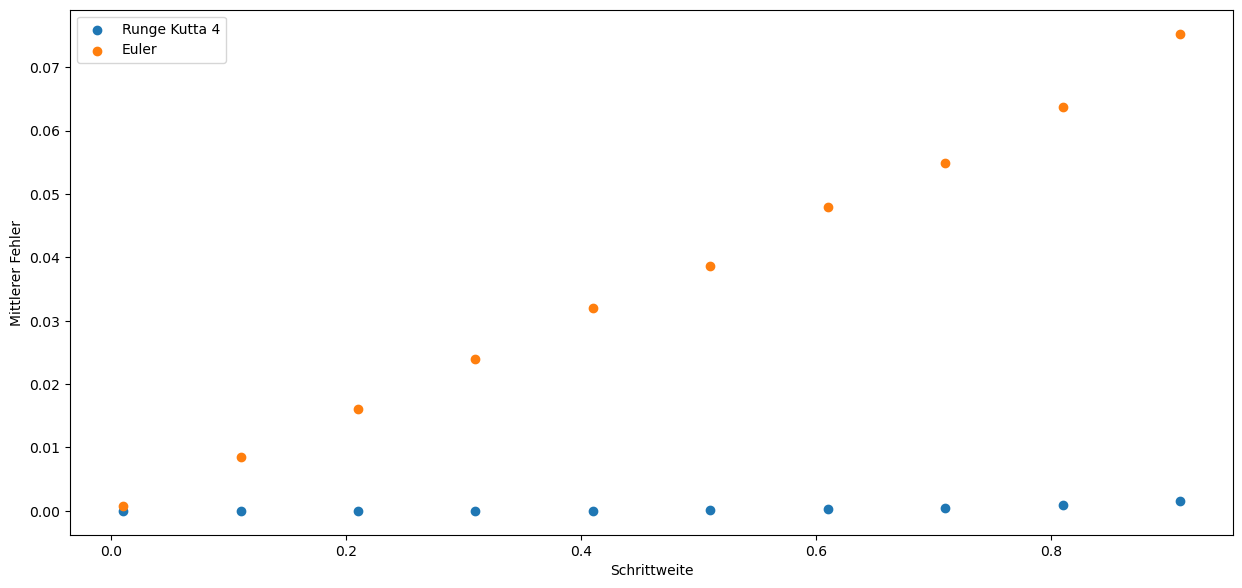

In [160]:
err_k4 = []
err_euler = []
schrittweiten = np.arange(0.01,1,0.1)
for h in schrittweiten:
    # Runge Kutta:
    y, x =runge_kutta4(0,dSdt,h=h,x0=0,xn=5)
    y_analytic = S_ana(x)
    mean_error = np.sum(np.abs(y- y_analytic))/len(y)
    err_k4.append(mean_error)
    # Euler:
    y, x = euler(0,dSdt,h=h,x0=0,xn=5)
    y_analytic = S_ana(x)
    mean_error = np.sum(np.abs(y- y_analytic))/len(y)
    err_euler.append(mean_error)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 1, 1)
ax.scatter(schrittweiten,err_k4, label = "Runge Kutta 4")
ax.scatter(schrittweiten,err_euler, label = "Euler")
ax.set_ylabel("Mittlerer Fehler")
ax.set_xlabel("Schrittweite")
ax.legend()


### Linearspeicher

Wir konstruieren nun einen einfachen Speicher, der mit dem Niederschlag aus der Wetterstation am Telegrafenberg gespeist wird.
- Volumen $V(t)$
- Abfluss $A(t)$
- Input $I(t)$
- Speicherkoeffizient $k$
$$ V(t) = V(t-1) - A(t-1) + I(t) $$
$$A(t-1) = k * V(t-1)$$

Zunächst lesen wir die Daten ein:

In [166]:
P_daily = pd.read_csv("data/niederschlag_tageswerte.csv",
            sep = ",",index_col=0)

Auswahl der letzten N [Tage] Beobachtungen:

In [162]:
N = 90
P_daily = P_daily.tail(N)

Der Input in den Speicher ist der Niederschlag P - Evapotranspiration (ET). Zu Übungszwecken schätzen wir die ET mit einem vereinfachten Verhältnis anhand der deutschlandweiten mittleren Wasserbilanz ab:

In [163]:

ET_P_ratio = ET/P
print("mittleres Verhältnis Evapotranspiration zu Niederschlag: ", ET_P_ratio)
ET_daily = P_daily * ET_P_ratio
# Input
I = (P_daily - ET_daily ).values # Input

mittleres Verhältnis Evapotranspiration zu Niederschlag:  0.6336861481822366


<Figure size 1500x1000 with 0 Axes>

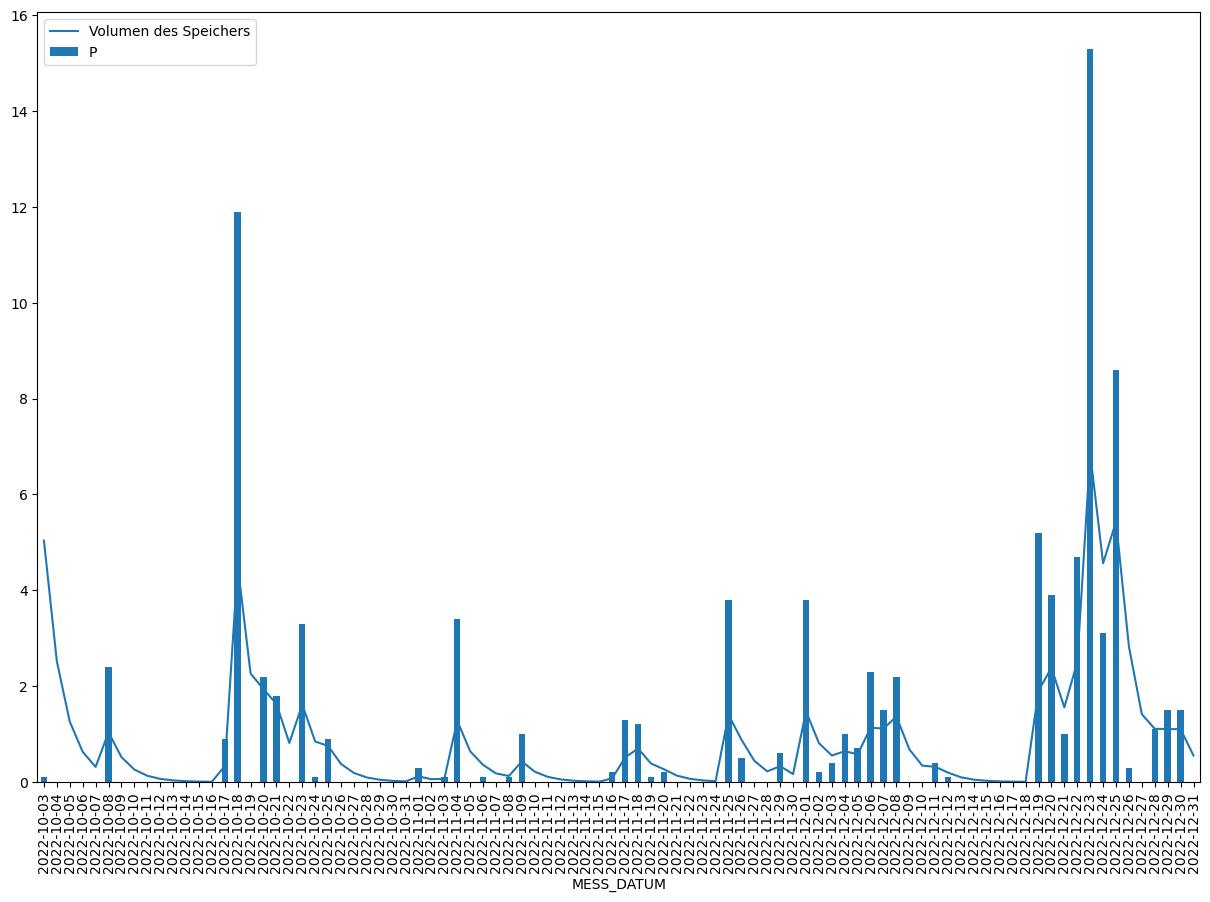

In [164]:

V = 10 # Startwert Volumen
k = 0.5 # Speicherkoeffizient 1
V_res = []
for i in range(len(I)):
    A = k*V # Abfluss
    V = V - A + I[i] # Speichervolumen
    V_res.append(V)

plt.figure(figsize=(15,10), )
P_daily.plot.bar(figsize=(15,10), label="Niederschlag")
plt.plot(V_res, label = "Volumen des Speichers")
plt.legend()
plt.show()

**Aufgabe:** Variere den Speicherkoeffizient und das Startvolumen. Wann fällt der Speicher nicht mehr trocken?

### Linearspeicher Kaskade:

Wir schalten nun einen zweiten Speicher hinter den ersten Speicher und erstellen damit eine lineare Speicherkaskade. Der Abfluss vom Speicher 1 speist dabei den Speicher 2. Damit können verschiedene Reaktionszeiten von Speichern modelliert werden (z.B. Direktabfluss/Basisabfluss).


- Input $I(t)$
- Volumen 1 $V1(t)$
- Abfluss 1 $A1(t)$
- Speicherkoeffizient 1 $k1$
$$ V1(t) = V1(t-1) - A1(t-1) + I(t) $$
$$A1(t-1) = k1 * V1(t-1)$$

- Volumen 2 $V2(t)$
- Abfluss 2 $A2(t)$
- Speicherkoeffizient 2 $k2$
$$ V2(t) = V2(t-1) - A2(t-1) + A1(t-1) $$
$$A2(t-1) = k2 * V2(t-1)$$

mittleres Verhältnis Evapotranspiration zu Niederschlag:  0.6336861481822366


<Figure size 1500x1000 with 0 Axes>

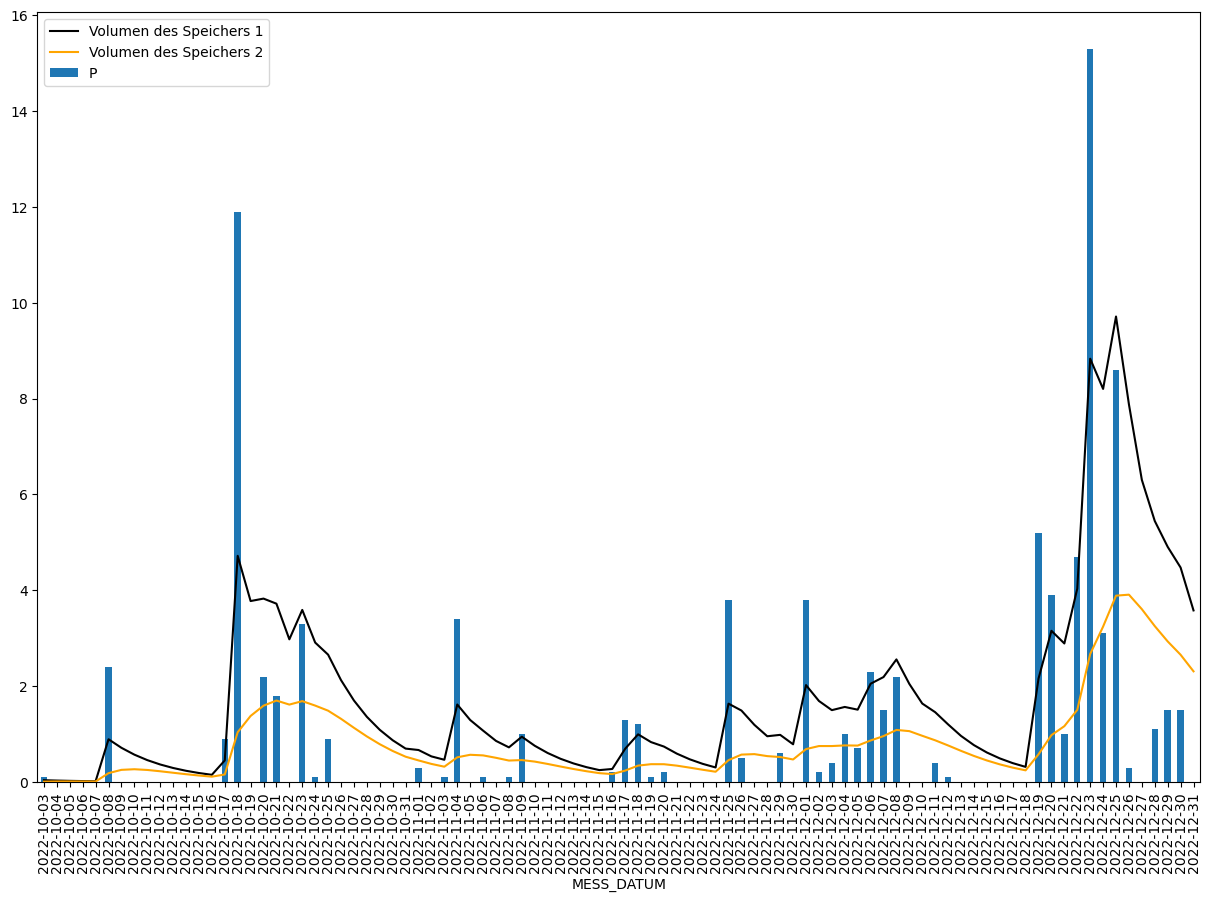

In [165]:
import matplotlib.pyplot as plt
ET_P_ratio = ET/P
print("mittleres Verhältnis Evapotranspiration zu Niederschlag: ", ET_P_ratio)
ET_daily = P_daily * ET_P_ratio
I = (P_daily - ET_daily ).values

V1 = 0 # Startwert Volumen 1
V2 = 0 # Startwert Volumen 2
A1 = 0 # Startwert Abfluss 1
A2 = 0 # Startwert Abfluss 2
k1 = 0.2 # Speicherkoeffizient 1
k2 = 0.4 # Speicherkoeffizient 2
V1_res = []
V2_res = []
# Auswertung über die Zeitschritte (aus Input)
for i in range(len(I)):
    V1 = V1 - A1 + I[i]
    A1 = k1 * V1
    V1_res.append(V1)

    V2 = V2 - A2 + A1
    A2 = k2*V2
    V2_res.append(V2)

plt.figure(figsize=(15,10), )
P_daily.plot.bar(figsize=(15,10), label="Niederschlag")
plt.plot(V1_res, label = "Volumen des Speichers 1",color="black")
plt.plot(V2_res, label = "Volumen des Speichers 2", color="orange")
plt.legend()
plt.show()